# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
from numpy.fft import *
import datetime

import matplotlib.pyplot as plt
import yaml
import datetime as dt
import scipy
import warnings

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA, AutoTheta, AutoCES
from statsforecast.utils import ConformalIntervals

from prophet import Prophet

import tensorflow as tf

import joblib

warnings.filterwarnings("ignore")

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Lecture du jeu de données

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  float64
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  float64
 7   atm             447136 non-null  float64
 8   col             447136 non-null  float64
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  float64
 13  prof            447136 non-null  float64
 14  plan            447136 non-null  float64
 15  surf            447136 non-null  float64
 16  infra           447136 non-null  float64
 17  situ           

### Séléction des colonnes qui nous intéressent ('jour', 'mois', 'an', 'grav')

In [4]:
liste = ['lum', 'dep', 'agg', 'int', 'atm', 'col', 'lat',
       'long', 'catr', 'circ', 'prof', 'plan', 'surf', 'infra', 'situ',
       'sexe', 'catv', 'obs', 'obsm', 'manv', 'motor', 'grav_rec', 'date',
       'weekend', 'heure', 'place_rec', 'age_usager', 'eq_ceinture',
       'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag', 'eq_gants',
       'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
df = df.drop(liste, axis = 1)
df.head()

jour  mois    an  grav
0    30    11  2019   4.0
1    30    11  2019   4.0
2    30    11  2019   1.0
3    30    11  2019   4.0
4    28    11  2019   1.0

### Sélection des lignes où grav = 4 (pour les blessés légers)

In [5]:
df_bl = df[df['grav'] == 4]
df_bl.head()

jour  mois    an  grav
0    30    11  2019   4.0
1    30    11  2019   4.0
3    30    11  2019   4.0
5    28    11  2019   4.0
6    28    11  2019   4.0

### Création de la série temporelle

In [6]:
y_m_j = df_bl['an'].astype('str') + "-" + df_bl['mois'].astype('str') + "-" + df_bl['jour'].astype('str')
df_bl.insert(loc = 0, column = 'y_m_j', value = y_m_j)
df_bl['y_m_j'] = pd.to_datetime(df_bl['y_m_j'])
df_bl = df_bl.drop(['an', 'mois', 'jour'], axis = 1)
df_bl.head()

y_m_j  grav
0 2019-11-30   4.0
1 2019-11-30   4.0
3 2019-11-30   4.0
5 2019-11-28   4.0
6 2019-11-28   4.0

In [7]:
df_bl['Nbre_Acc'] = 1
df_bl = df_bl.drop('grav', axis = 1)
df_bl = df_bl[['y_m_j', 'Nbre_Acc']].groupby('y_m_j').sum().reset_index()
df_bl.head()

y_m_j  Nbre_Acc
0 2019-01-01        92
1 2019-01-02        81
2 2019-01-03        83
3 2019-01-04       105
4 2019-01-05       105

In [8]:
df_bl = df_bl.set_index('y_m_j')
df_bl.head()


Nbre_Acc
y_m_j               
2019-01-01        92
2019-01-02        81
2019-01-03        83
2019-01-04       105
2019-01-05       105

# Etude de la tendance, de la saisonnalité et du bruit pour les années 2020 à 2022

In [9]:
plt.figure(figsize = (15, 5))
plt.plot(df_bl)
plt.xlabel('Dates')
plt.ylabel("Nombre de blessés légers")
plt.title("Évolution du nombre de blessés légers")
plt.xlim(df_bl.index[0], df_bl.index[-1])
plt.annotate('Confinement 1', xy = (df_bl.index[470], 125), xytext = (df_bl.index[470], 210), arrowprops = {'facecolor' : 'red'})
plt.annotate('Confinement 2', xy = (df_bl.index[680], 125), xytext = (df_bl.index[680], 210), arrowprops = {'facecolor' : 'red'})
plt.show()

On voit une diminution du nombre de tué en 2020, certainement due aux confinement de mars et octobre.
Pour ne pas biaiser le jeu de donnée, nous allons nous concentrer sur les années 2021 et 2022.

In [10]:
df_bl = df_bl[df_bl.index >= '2021-01-01']
df_bl
df2 = df_bl.copy()

### Visualisation du nombre de tués en fonction du mois

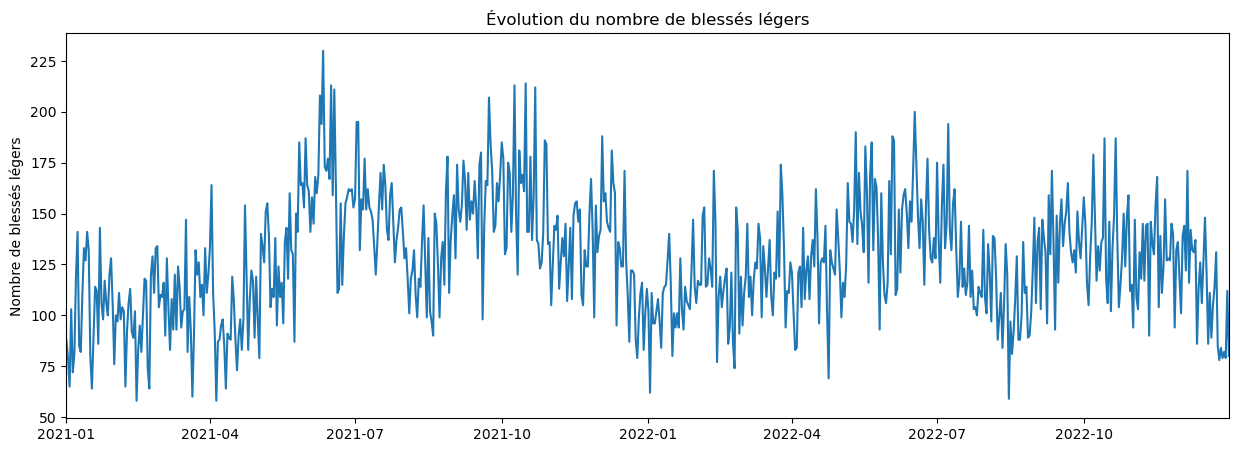

In [11]:
plt.figure(figsize = (15, 5))
plt.plot(df_bl)
plt.ylabel("Nombre de blessés légers")
plt.title("Évolution du nombre de blessés légers")
plt.xlim(df_bl.index[0], df_bl.index[-1])
plt.show()

La courbe montre que l'écart les points maximaux et les points minimaux n'augmente pas. On est dans le cas d'un modèle additif.

### La tendance

In [12]:
win = [7, 15, 21, 28, 182, 365]
fig = plt.figure(figsize = (25, 10))
plt.title("Tendance pour les blessés légers", {'fontsize' : 20})
plt.axis('off')

for i in range(len(win)):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(df_bl)
    ax.plot(df_bl.rolling(win[i], center = True).mean(), label = f"moyenne sur {win[i]} jours")
    ax.tick_params(axis = 'x', labelrotation = 45)
    ax.legend()
    

plt.show()

En prenant un fenêtre de 365 jours, une tendance linéaire et stable est bien visible.   
Le fait que cette tendance est identifiable pour des fenêtre glissante dont la taille est un multiple de 365 mois suggère une notion de saisonnalité annuelle.

### La saisonnalité

In [13]:
df_bl['an'] = df_bl.index.year
df_bl['jour_semaine'] = df_bl.index.day_name()
df_bl

Nbre_Acc    an jour_semaine
y_m_j                                  
2021-01-01        88  2021       Friday
2021-01-02        79  2021     Saturday
2021-01-03        65  2021       Sunday
2021-01-04       103  2021       Monday
2021-01-05        72  2021      Tuesday
...              ...   ...          ...
2022-12-27        79  2022      Tuesday
2022-12-28        82  2022    Wednesday
2022-12-29        79  2022     Thursday
2022-12-30       112  2022       Friday
2022-12-31        80  2022     Saturday

[730 rows x 3 columns]

In [14]:
df_bl_moy = df_bl[['an', 'jour_semaine', 'Nbre_Acc']].groupby(['an', 'jour_semaine']).mean().reset_index()
df_bl_moy

an jour_semaine    Nbre_Acc
0   2021       Friday  148.584906
1   2021       Monday  122.288462
2   2021     Saturday  134.250000
3   2021       Sunday  111.865385
4   2021     Thursday  130.923077
5   2021      Tuesday  131.634615
6   2021    Wednesday  132.115385
7   2022       Friday  143.500000
8   2022       Monday  119.384615
9   2022     Saturday  134.264151
10  2022       Sunday  112.038462
11  2022     Thursday  118.807692
12  2022      Tuesday  122.884615
13  2022    Wednesday  127.615385

In [15]:
plt.figure(figsize = (12, 6))

yrs = df_bl['an'].unique()

for i in yrs :
    plt.plot(df_bl_moy['jour_semaine'][df_bl_moy['an'] == i], df_bl_moy["Nbre_Acc"][df_bl_moy['an'] == i], label = i)

plt.legend(bbox_to_anchor = (1, 1)) 
plt.title('Moyenne annuelle des blessés légers selon les jours de la semaine', {'fontsize' : 20})
plt.show()

In [16]:
df_bl = df_bl.drop(['an', 'jour_semaine'], axis = 1)
df_bl.head()

Nbre_Acc
y_m_j               
2021-01-01        88
2021-01-02        79
2021-01-03        65
2021-01-04       103
2021-01-05        72

Les variations du nombre de tués sur une année ont une tendance similaire. Il semblerait que l'on ait une saisonnalité.

### Le bruit

In [17]:
res = seasonal_decompose(df_bl, model = 'additive')
fig = res.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

Le bruit est important. Il faudra sûrement faire une différenciation.

# Création d'une baseline avec une méthode naïve

### Création de la colonne Nbre_Acc_t-1

In [18]:
df_naive = df_bl
df_naive['Nbre_Acc_t-1'] = df_naive['Nbre_Acc'].shift(1)
df_naive

Nbre_Acc  Nbre_Acc_t-1
y_m_j                             
2021-01-01        88           NaN
2021-01-02        79          88.0
2021-01-03        65          79.0
2021-01-04       103          65.0
2021-01-05        72         103.0
...              ...           ...
2022-12-27        79          84.0
2022-12-28        82          79.0
2022-12-29        79          82.0
2022-12-30       112          79.0
2022-12-31        80         112.0

[730 rows x 2 columns]

In [19]:
df_naive = df_naive.dropna()
df_naive

Nbre_Acc  Nbre_Acc_t-1
y_m_j                             
2021-01-02        79          88.0
2021-01-03        65          79.0
2021-01-04       103          65.0
2021-01-05        72         103.0
2021-01-06        81          72.0
...              ...           ...
2022-12-27        79          84.0
2022-12-28        82          79.0
2022-12-29        79          82.0
2022-12-30       112          79.0
2022-12-31        80         112.0

[729 rows x 2 columns]

In [20]:
# Sauvegarde du DataFrame
df_naive.to_csv("../../../data/saved_models/Blesses_legers_Baseline_shift1.csv")

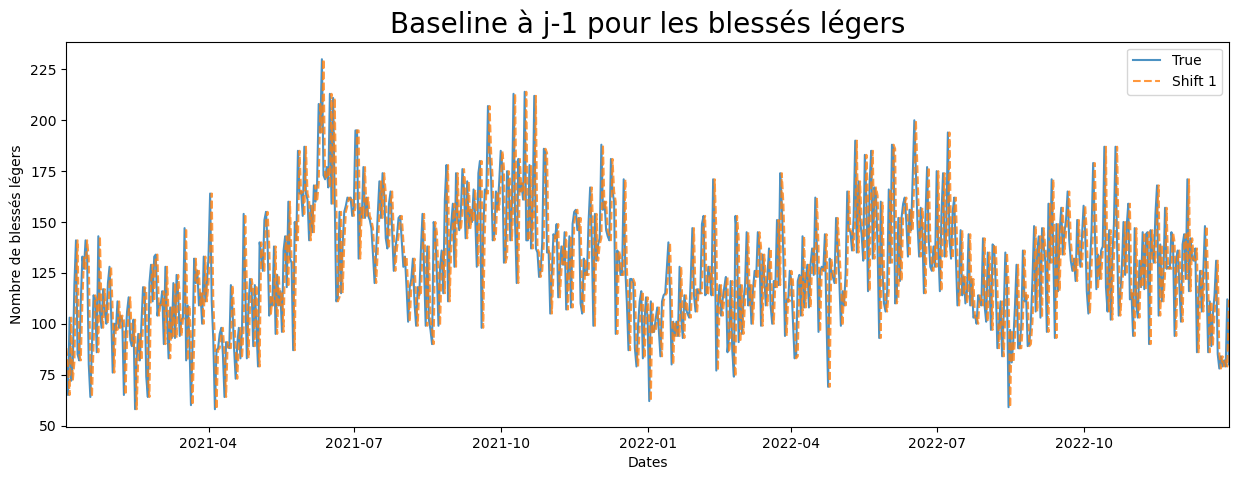

In [21]:
plt.figure(figsize = (15, 5))
plt.plot(df_naive.index, df_naive['Nbre_Acc'], alpha = 0.8, label = 'True')
plt.plot(df_naive.index, df_naive['Nbre_Acc_t-1'], alpha = 0.8, label = 'Shift 1', linestyle = "dashed")
plt.legend()
plt.xlim(df_naive.index[0], df_naive.index[-1])
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés légers')
plt.title("Baseline à j-1 pour les blessés légers", {'fontsize' : 20})
plt.show()

In [22]:
true = df_naive['Nbre_Acc']
prediction = df_naive['Nbre_Acc_t-1']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(true, prediction)
train_mse = mean_squared_error(true, prediction)
train_rmse = mean_squared_error(true, prediction, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
})

print(performance_df)

  Métrique  Ensemble d'entraînement
0      MAE                21.799726
1      MSE               739.497942
2     RMSE                27.193711


### Création de la colonne Nbre_Acc_rm (moyenne des 7 jours précédents)

In [23]:
df_naive = df_bl
df_naive['Nbre_Acc_t-1'] = df_naive['Nbre_Acc'].rolling(7).mean().shift(1)
df_naive

Nbre_Acc  Nbre_Acc_t-1
y_m_j                             
2021-01-01        88           NaN
2021-01-02        79           NaN
2021-01-03        65           NaN
2021-01-04       103           NaN
2021-01-05        72           NaN
...              ...           ...
2022-12-27        79     98.000000
2022-12-28        82     96.571429
2022-12-29        79     93.285714
2022-12-30       112     88.285714
2022-12-31        80     85.571429

[730 rows x 2 columns]

In [24]:
df_naive = df_naive.dropna()
df_naive

Nbre_Acc  Nbre_Acc_t-1
y_m_j                             
2021-01-08       141     86.714286
2021-01-09        85     94.285714
2021-01-10        82     95.142857
2021-01-11       110     97.571429
2021-01-12       133     98.571429
...              ...           ...
2022-12-27        79     98.000000
2022-12-28        82     96.571429
2022-12-29        79     93.285714
2022-12-30       112     88.285714
2022-12-31        80     85.571429

[723 rows x 2 columns]

In [25]:
# Sauvegarde du DataFrame
df_naive.to_csv("../../../data/saved_models/Blesses_legers_Baseline_moy7+shift1.csv")

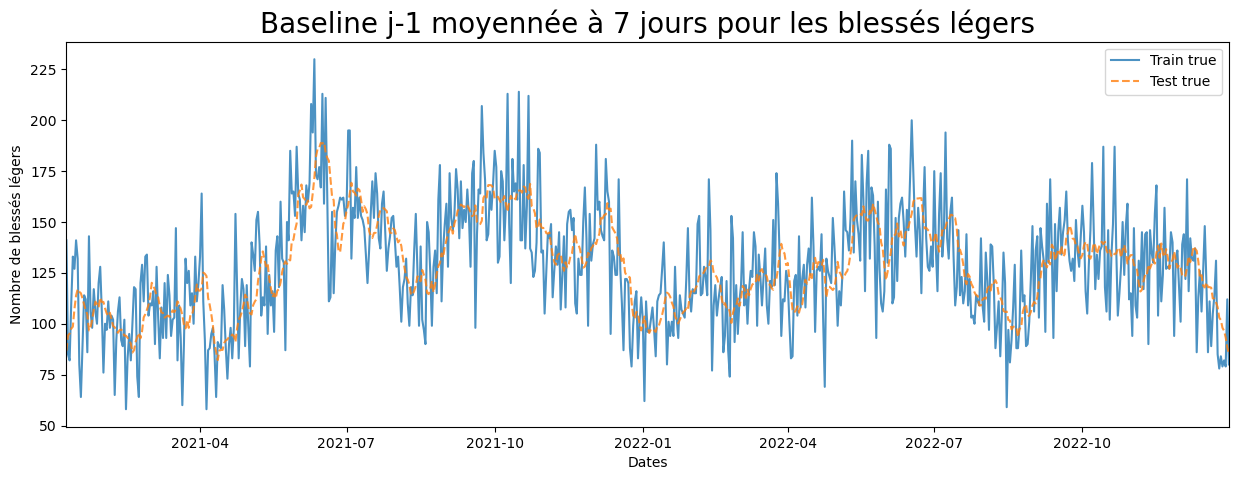

In [26]:
plt.figure(figsize = (15, 5))
plt.plot(df_naive.index, df_naive['Nbre_Acc'], alpha = 0.8, label = 'Train true')
plt.plot(df_naive.index, df_naive['Nbre_Acc_t-1'], alpha = 0.8, label = 'Test true', linestyle = "dashed")
plt.legend()
plt.xlim(df_naive.index[0], df_naive.index[-1])
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés légers')
plt.title("Baseline j-1 moyennée à 7 jours pour les blessés légers", {'fontsize' : 20})
plt.show()

In [27]:
true = df_naive['Nbre_Acc']
prediction = df_naive['Nbre_Acc_t-1']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(true, prediction)
train_mse = mean_squared_error(true, prediction)
train_rmse = mean_squared_error(true, prediction, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
})

print(performance_df)

  Métrique  Ensemble d'entraînement
0      MAE                17.568070
1      MSE               494.980552
2     RMSE                22.248158


# Entraînement et évaluation d'un modèle SARIMA

In [28]:
df_bl = df_bl.drop('Nbre_Acc_t-1', axis = 1)
df_bl.head()

Nbre_Acc
y_m_j               
2021-01-01        88
2021-01-02        79
2021-01-03        65
2021-01-04       103
2021-01-05        72

In [29]:
# Sauvegarde du DataFrame
df_bl.to_csv("../../../data/saved_models/Blesses_legers_Sarimax.csv")

### Stationarisation de la série

In [30]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        
check_stationarity(df_bl)

ADF Statistic: -2.662557
p-value: 0.080745
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Non-stationary


On fait une différenciation d'ordre 1 pour stationnariser.

In [31]:
df_bl_1 = df_bl.diff().dropna()
check_stationarity(df_bl_1)

ADF Statistic: -8.155546
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Stationary


### Vérification de la saisonnalité à 365 jours

Méthodologie issue de : https://www.kaggle.com/code/saisatishmasina/sarima-with-fourier-terms
pour l'analyse de la qualité de l'air

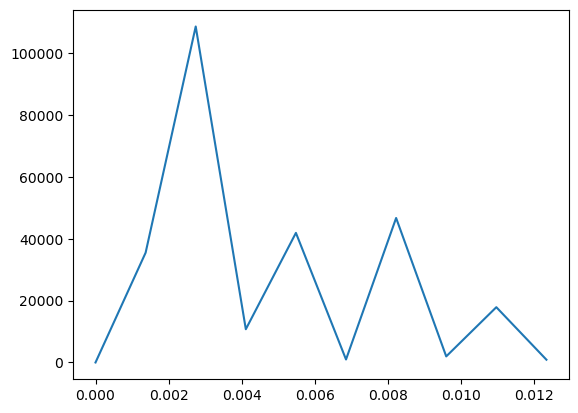

In [32]:
freq, PSD = scipy.signal.periodogram(df_bl['Nbre_Acc'].values)
plt.plot(freq[:10], PSD[:10]) # checking the lower frequencies

In [33]:
periodogram = pd.DataFrame({"Period": (1/freq), "Power Spectral Density": PSD}).round(2)

periodogram[:10]

Period  Power Spectral Density
0     inf                    0.00
1  730.00                35481.18
2  365.00               108591.35
3  243.33                10748.04
4  182.50                41885.70
5  146.00                  969.39
6  121.67                46699.13
7  104.29                 1963.63
8   91.25                17866.31
9   81.11                  895.83

In [34]:
""" Confirme la saisonnalité de 365 jours"""

' Confirme la saisonnalité de 365 jours'

### Séparation en train et test

In [35]:
train, test = train_test_split(df_bl, test_size = 0.1, shuffle = False)

In [36]:
x = train['Nbre_Acc'].values

### Extrapolation de la série de Fourier

In [37]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    
    n_harm = 20                     # number of harmonics in model
    
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    
    x_notrend = x - p[0] * t        # detrended x
    
    x_freqdom = fft(x_notrend)  # detrended x in frequency domain
    f = fftfreq(n)              # frequencies
    
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    
    return restored_sig + p[0] * t

exog = fourierExtrapolation(x, len(test))

print("Shape of Exogenous Regressor (Fourier Extraction) for seasonality: ", exog.shape)

Shape of Exogenous Regressor (Fourier Extraction) for seasonality:  (730,)


In [38]:
train.shape[0]+test.shape[0]

730

In [39]:
train['exog'] = exog[:len(train)]
test['exog'] = exog[len(train):]

### Courbes d'Autocorrélation et d'Autocorrélation partielle

In [40]:
Ndiff=2
signal=train.Nbre_Acc.diff(Ndiff).dropna()

# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(311)
ax.set_xlabel("signal")
plt.plot(signal)

ax = plt.subplot(312)
ax.set_xlabel("Lag")
sm.graphics.tsa.plot_acf(signal, lags=49, ax=ax)

ax = plt.subplot(313)
ax.set_xlabel("Lag")
sm.graphics.tsa.plot_pacf(signal, lags=49, ax=ax)

plt.suptitle("ACF and PACF")
plt.tight_layout()
plt.show()

### Entraînement du modèle et résultats

In [41]:
# Initial approximation of parameters
Qs = range(0,3) 
qs = range(0,3)
Ps = range(0,3)
ps = range(0,3)
D=1
d=2

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


def bestmodel(parameters_list, df):
    # Model Selection
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')

    for param in parameters_list:
        
        try:
            model=sm.tsa.statespace.SARIMAX(train.Nbre_Acc, exog=train['exog'],order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 7), enforce_stationarity=False).fit(disp=-1)
        except ValueError:
            print('wrong parameters:', param)
            continue

        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        
        results.append([param, model.aic])
    return results, best_model

results, best_model = bestmodel(parameters_list, train)

In [42]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters (p,q,P,Q)', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

   parameters (p,q,P,Q)          aic
47         (1, 2, 0, 2)  5472.422638
74         (2, 2, 0, 2)  5472.880742
50         (1, 2, 1, 2)  5474.216642
80         (2, 2, 2, 2)  5476.448484
20         (0, 2, 0, 2)  5480.424990
                                     SARIMAX Results                                     
Dep. Variable:                          Nbre_Acc   No. Observations:                  657
Model:             SARIMAX(1, 2, 2)x(0, 1, 2, 7)   Log Likelihood               -2729.211
Date:                           Thu, 30 May 2024   AIC                           5472.423
Time:                                   14:51:11   BIC                           5503.554
Sample:                               01-01-2021   HQIC                          5484.514
                                    - 10-19-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|    

On voit que le P>|z| de ma.S.L14 est supérieur à 5%. On essaie donc le modèle SARIMAX(1, 2, 2)x(0, 1, 1, 7)

In [43]:
model = sm.tsa.statespace.SARIMAX(train.Nbre_Acc, exog=train['exog'], order = (1, 2, 2), seasonal_order = (0, 1, 1, 7), enforce_stationarity=False)
sarimax = model.fit(disp = -1)
print(sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Nbre_Acc   No. Observations:                  657
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 7)   Log Likelihood               -2762.300
Date:                             Thu, 30 May 2024   AIC                           5536.600
Time:                                     14:51:11   BIC                           5563.350
Sample:                                 01-01-2021   HQIC                          5546.985
                                      - 10-19-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog           1.0029      0.029     34.161      0.000       0.945       1.060
ar.L1          0.1413      

In [44]:
joblib.dump(sarimax, "../../../data/saved_models/Blesses_legers_Sarimax.joblib")

['../../../data/saved_models/Blesses_legers_Sarimax.joblib']

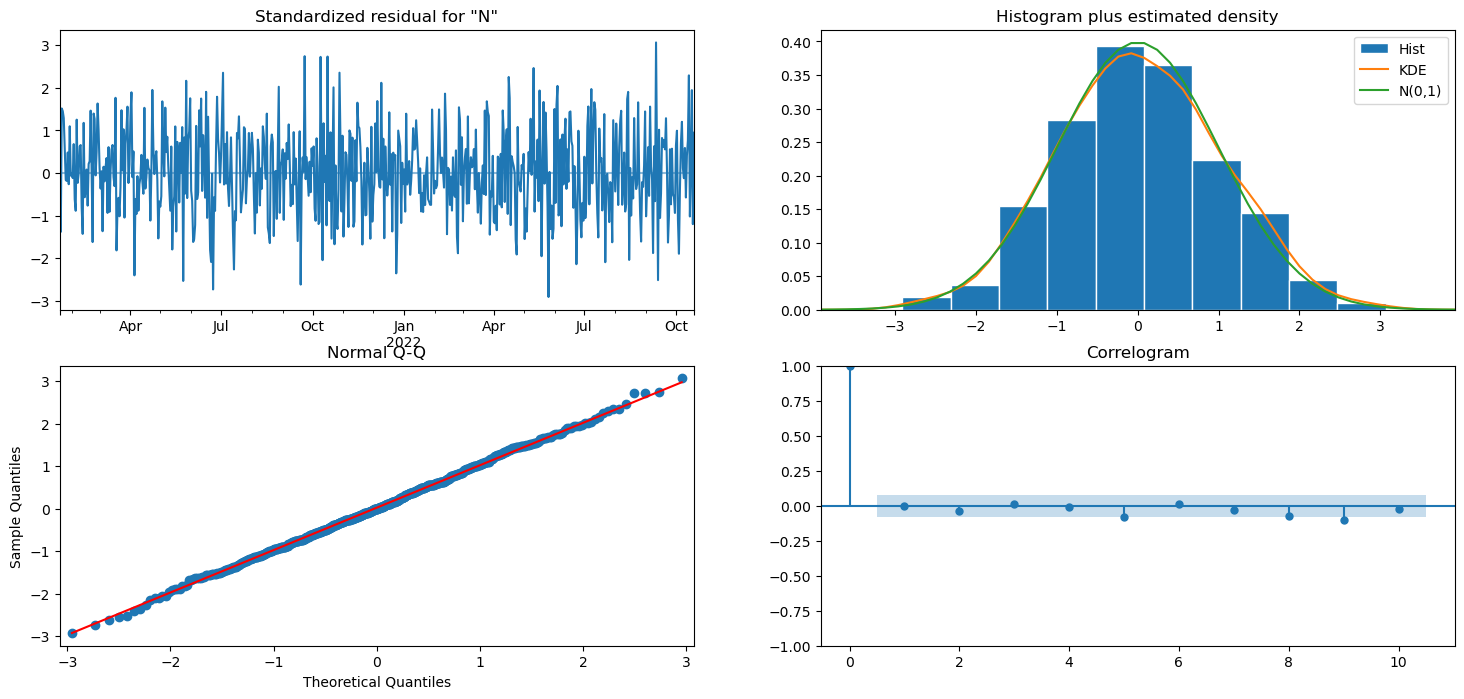

In [45]:
sarimax.plot_diagnostics(figsize=(18, 8))
plt.show()

### Évaluation du modèle

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train.plot(ax=ax)

# Construct the forecasts
fcast = sarimax.get_forecast(len(test), exog= test['exog']).summary_frame()
fcast.index = test.index
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)

test.plot(ax=ax)

plt.title("SARIMAX with fourier terms FORECAST")
plt.legend(["Train", "Fourier series for Train", "SARIMAX prediction", "std SARIMAX prediction", "Test", "Fourier series for Test"])
plt.xlabel("DATE")
plt.ylabel("Num_Acc")

Text(0, 0.5, 'Num_Acc')

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train[-90 : ].plot(ax=ax)

# Construct the forecasts
fcast = sarimax.get_forecast(len(test), exog= test['exog']).summary_frame()
fcast.index = test.index
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)

test.plot(ax=ax)

plt.title("SARIMAX with fourier terms FORECAST")
plt.legend(["Train", "Fourier series for Train", "SARIMAX prediction", "std SARIMAX prediction", "Test", "Fourier series for Test"])
plt.xlabel("DATE")
plt.ylabel("Num_Acc")

Text(0, 0.5, 'Num_Acc')

In [48]:
train_predictions = sarimax.get_forecast(len(train), exog= train['exog']).summary_frame()['mean']
test_predictions = sarimax.get_forecast(len(test), exog= test['exog']).summary_frame()['mean']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['Nbre_Acc'], train_predictions)
train_mse = mean_squared_error(train['Nbre_Acc'], train_predictions)
train_rmse = mean_squared_error(train['Nbre_Acc'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['Nbre_Acc'], test_predictions)
test_mse = mean_squared_error(test['Nbre_Acc'], test_predictions)
test_rmse = mean_squared_error(test['Nbre_Acc'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                33.115539         21.352262
1      MSE              1588.257639        688.499658
2     RMSE                39.852950         26.239277


Erreurs avec la série de Fourier

In [49]:
true_values = test.Nbre_Acc.values
pred_values = test.exog.values

test_mae_fourier = mean_absolute_error(y_pred=pred_values, y_true=true_values)
test_mse_fourier = mean_squared_error(y_pred=pred_values, y_true=true_values)
test_rmse_fourier = mean_squared_error(y_pred=pred_values, y_true=true_values, squared=False)

print("MAE: ",test_mae_fourier)
print("MSE: ",test_mse_fourier)
print("RMSE: ",test_rmse_fourier)

MAE:  22.35748958694928
MSE:  716.3790891421925
RMSE:  26.7652589963593


### Prévisions

On ne peut pas faire de prévisions car on ne peut pas prédire la série de Fourier pour la mettre en exog dans SARIMAX.

# Entraînement et évaluation d'un modèle MSTL

### Preparation du jeu de données

In [50]:
df_bl2 = df2
df_bl2 = df_bl2.reset_index()
df_bl2

y_m_j  Nbre_Acc
0   2021-01-01        88
1   2021-01-02        79
2   2021-01-03        65
3   2021-01-04       103
4   2021-01-05        72
..         ...       ...
725 2022-12-27        79
726 2022-12-28        82
727 2022-12-29        79
728 2022-12-30       112
729 2022-12-31        80

[730 rows x 2 columns]

In [51]:
df_bl2 = df_bl2.rename(columns = {'y_m_j' : 'ds', 'Nbre_Acc' : 'y'})
df_bl2['unique_id'] = "1"
df_bl2.head()

ds    y unique_id
0 2021-01-01   88         1
1 2021-01-02   79         1
2 2021-01-03   65         1
3 2021-01-04  103         1
4 2021-01-05   72         1

In [52]:
df_bl2 = df_bl2[df_bl2['ds'] >= '2021-01-01'].reset_index()
df_bl2 = df_bl2.drop('index', axis = 1)
df_bl2.head()

ds    y unique_id
0 2021-01-01   88         1
1 2021-01-02   79         1
2 2021-01-03   65         1
3 2021-01-04  103         1
4 2021-01-05   72         1

In [53]:
# Sauvegarde du DataFrame
df_bl2.to_csv("../../../data/saved_models/Blesses_legers_MSTL.csv")

### Exploration du jeu de données

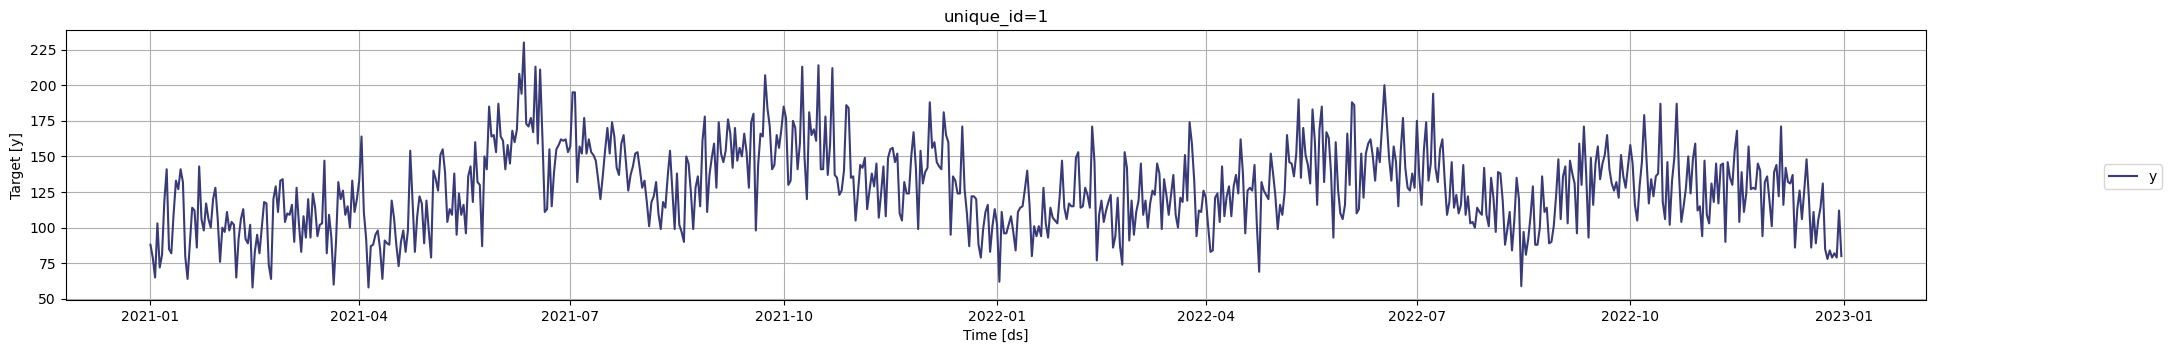

In [54]:
StatsForecast.plot(df_bl2)

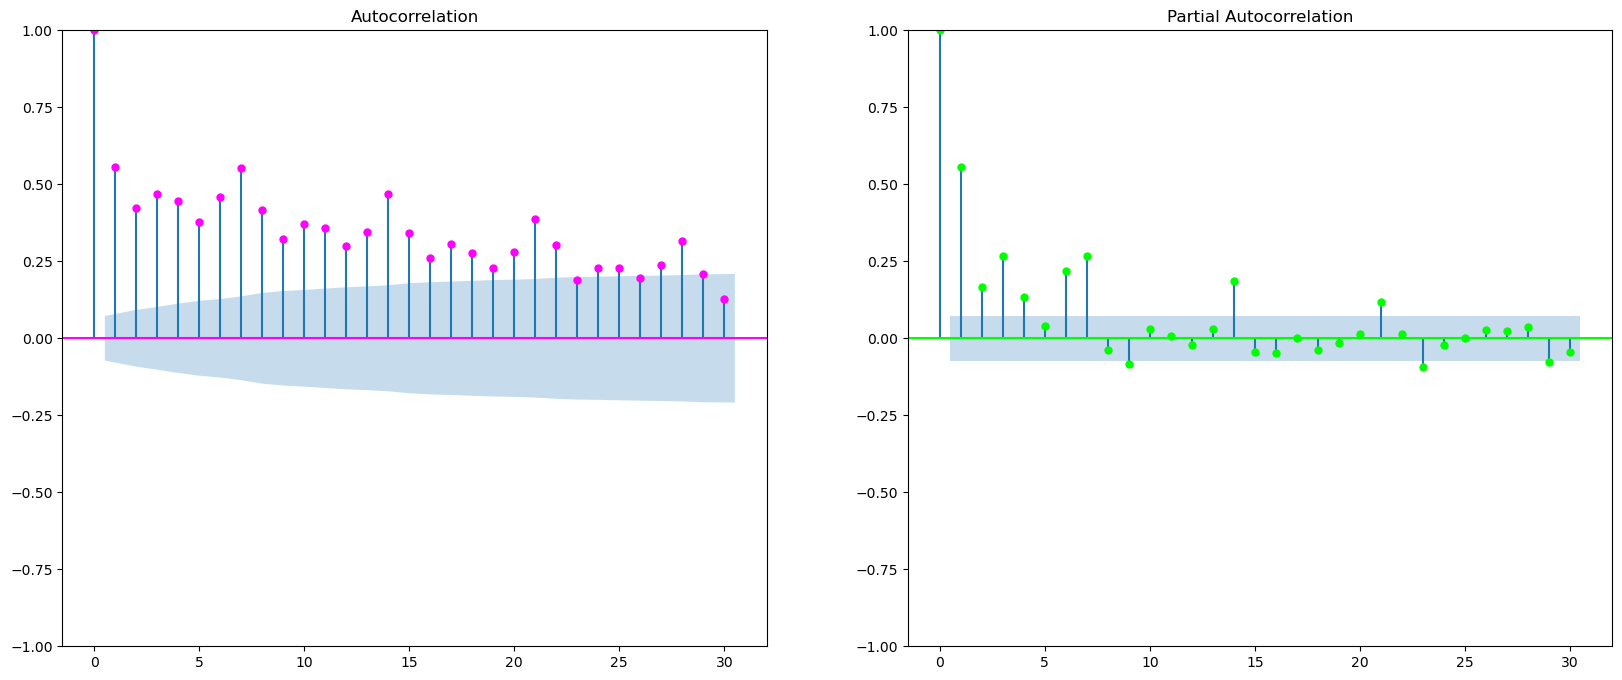

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))

plot_acf(df_bl2["y"], lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation")

# Grafico
plot_pacf(df_bl2["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show()

On voit bien la saisonnalité sur 7 jours.

### Séparation en train et test

In [56]:
train, test = train_test_split(df_bl2, test_size = 0.1, shuffle = False)

In [57]:
train.shape, test.shape

((657, 3), (73, 3))

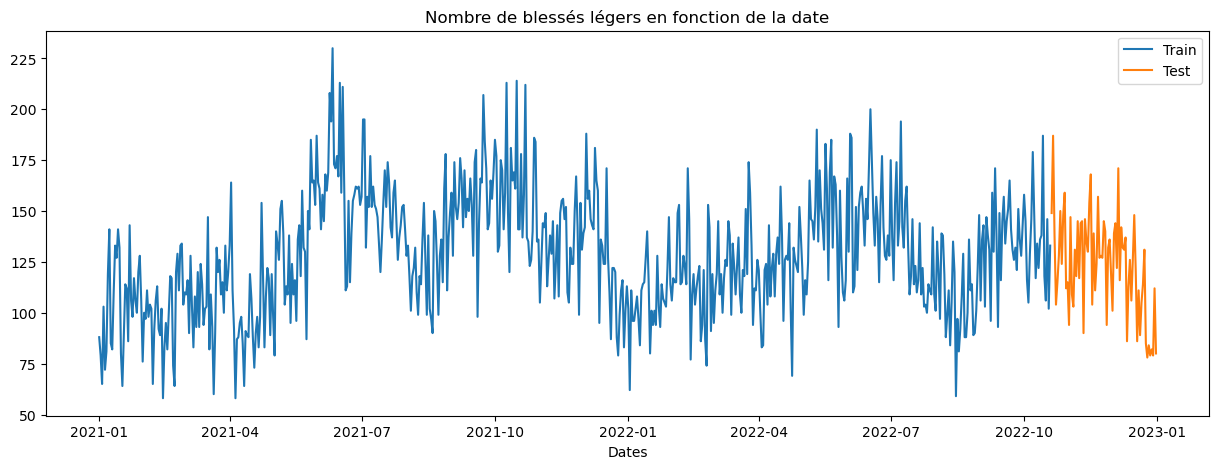

In [58]:
plt.figure(figsize=(15, 5))
plt.plot(train["ds"], train["y"], label = "Train")
plt.plot(test["ds"], test["y"], label="Test")
plt.title("Nombre de blessés légers en fonction de la date")
plt.xlabel("Dates")
plt.legend()
plt.show()

### Implémentation du modèle MSTL avec AutoARIMA comme trend_forecaster

In [59]:
horizon = len(test)

models = [MSTL(season_length=[7, 7 * 52], 
               trend_forecaster=AutoARIMA(prediction_intervals=ConformalIntervals(n_windows=3, h=horizon)))]

In [60]:
sf = StatsForecast(models = models,
                   freq = 'D',     
                   n_jobs = -1)

• Entraînement du modèle

In [61]:
sf.fit(df = train)

StatsForecast(models=[MSTL])

In [62]:
result=sf.fitted_[0,0].model_
result

data       trend  seasonal7  seasonal364  remainder
0     88.0  122.214270  20.245240   -47.023409  -7.436100
1     79.0  122.259299  -3.951599   -38.606091  -0.701609
2     65.0  122.304296 -25.063061   -41.962118   9.720884
3    103.0  122.349259  -4.318888   -19.193107   4.162736
4     72.0  122.394189   3.719976   -46.825632  -7.288534
..     ...         ...        ...          ...        ...
652  118.0  116.295582   0.780056    30.783448 -29.859086
653  106.0  116.227801  -5.225436     9.424647 -14.427012
654  146.0  116.159956  -2.594345    29.628621   2.805768
655  102.0  116.092046 -13.098937    16.718293 -17.711403
656  133.0  116.024072   7.531436     4.960499   4.483992

[657 rows x 5 columns]

In [63]:
sf.fitted_[0, 0].model_.tail(7 * 52 * 2).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

In [64]:
Y_test_pred = sf.forecast(horizon, fitted=True)
Y_test_pred

ds        MSTL
unique_id                       
1         2022-10-20  125.871765
1         2022-10-21  199.268906
1         2022-10-22  100.732529
1         2022-10-23  125.919930
1         2022-10-24  118.135185
...              ...         ...
1         2022-12-27   81.240852
1         2022-12-28   71.903534
1         2022-12-29   68.575691
1         2022-12-30   86.879425
1         2022-12-31   75.624702

[73 rows x 2 columns]

In [65]:
values = sf.forecast_fitted_values()
values.head()

ds      y        MSTL
unique_id                              
1         2021-01-01   88.0   87.885223
1         2021-01-02   79.0   73.576500
1         2021-01-03   65.0   53.101440
1         2021-01-04  103.0  101.237381
1         2021-01-05   72.0   80.267807

In [66]:
Y_test_pred = Y_test_pred.reset_index()
Y_test_pred

unique_id         ds        MSTL
0          1 2022-10-20  125.871765
1          1 2022-10-21  199.268906
2          1 2022-10-22  100.732529
3          1 2022-10-23  125.919930
4          1 2022-10-24  118.135185
..       ...        ...         ...
68         1 2022-12-27   81.240852
69         1 2022-12-28   71.903534
70         1 2022-12-29   68.575691
71         1 2022-12-30   86.879425
72         1 2022-12-31   75.624702

[73 rows x 3 columns]

In [67]:
Y_test_pred1 = Y_test_pred.merge(right = test, how = 'inner', on = ['ds', 'unique_id'])
Y_test_pred1

unique_id         ds        MSTL    y
0          1 2022-10-20  125.871765  149
1          1 2022-10-21  199.268906  187
2          1 2022-10-22  100.732529  138
3          1 2022-10-23  125.919930  104
4          1 2022-10-24  118.135185  115
..       ...        ...         ...  ...
68         1 2022-12-27   81.240852   79
69         1 2022-12-28   71.903534   82
70         1 2022-12-29   68.575691   79
71         1 2022-12-30   86.879425  112
72         1 2022-12-31   75.624702   80

[73 rows x 4 columns]

In [68]:
plt.figure(figsize = (15, 5))
plt.plot(values['ds'], values['y'], alpha = 0.8, label = 'Train true')
plt.plot(values['ds'], values['MSTL'], alpha = 0.8, label = 'Train MSTL', linestyle = "dashed")
plt.plot(Y_test_pred1['ds'], Y_test_pred1['y'], alpha = 0.8, label = 'Test true')
plt.plot(Y_test_pred1['ds'], Y_test_pred1['MSTL'], alpha = 0.8, label = 'Test MSTL', linestyle = "dashed")
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de  blessés légers')
plt.title("MSTL forecast pour les  blessés légers")
plt.show()

In [69]:
fcast = sf.forecast(h=horizon, level=[95])
fcast

ds        MSTL  MSTL-lo-95  MSTL-hi-95
unique_id                                               
1         2022-10-20  125.871765  121.858093  129.885422
1         2022-10-21  199.268906  172.237289  226.300537
1         2022-10-22  100.732529   78.694077  122.770981
1         2022-10-23  125.919930   84.423431  167.416428
1         2022-10-24  118.135185   88.063026  148.207352
...              ...         ...         ...         ...
1         2022-12-27   81.240852   50.682278  111.799431
1         2022-12-28   71.903534   39.576977  104.230095
1         2022-12-29   68.575691   62.340744   74.810638
1         2022-12-30   86.879425   66.429779  107.329071
1         2022-12-31   75.624702   35.739796  115.509605

[73 rows x 4 columns]

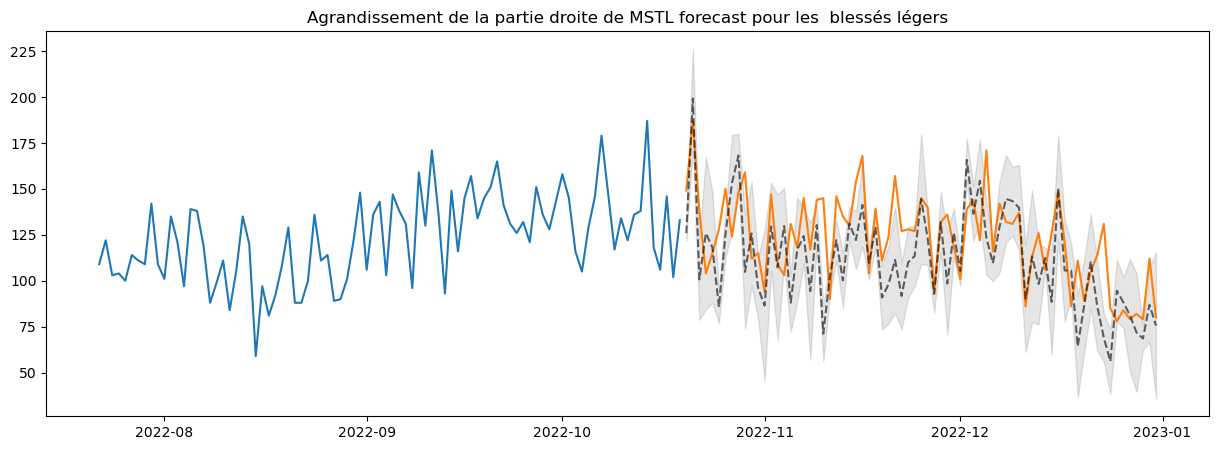

In [70]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(values['ds'][-90 :], values['y'][-90 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(fcast['ds'], fcast['MSTL'], "k--",label = 'Test MSTL', alpha = 0.6)
ax.fill_between(fcast['ds'], fcast['MSTL-lo-95'], fcast['MSTL-hi-95'], color='k', alpha=0.1)
ax.set_title("Agrandissement de la partie droite de MSTL forecast pour les  blessés légers")
plt.show()

• Evaluation du modèle

In [71]:
train_predictions = values['MSTL']
test_predictions = Y_test_pred1['MSTL']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                 8.704782         19.503647
1      MSE               135.005529        630.389345
2     RMSE                11.619188         25.107556


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [72]:
sf.fit(df = df_bl2)

StatsForecast(models=[MSTL])

Prédiction pour les 6 prochains mois

In [73]:
horizon = 181

In [74]:
Y_pred = sf.forecast(horizon, fitted=True)
Y_pred

ds        MSTL
unique_id                       
1         2023-01-01   57.683506
1         2023-01-02  107.341949
1         2023-01-03   67.685852
1         2023-01-04   80.921082
1         2023-01-05   95.071510
...              ...         ...
1         2023-06-26  152.443268
1         2023-06-27  129.812225
1         2023-06-28  143.801163
1         2023-06-29  137.136841
1         2023-06-30  173.528076

[181 rows x 2 columns]

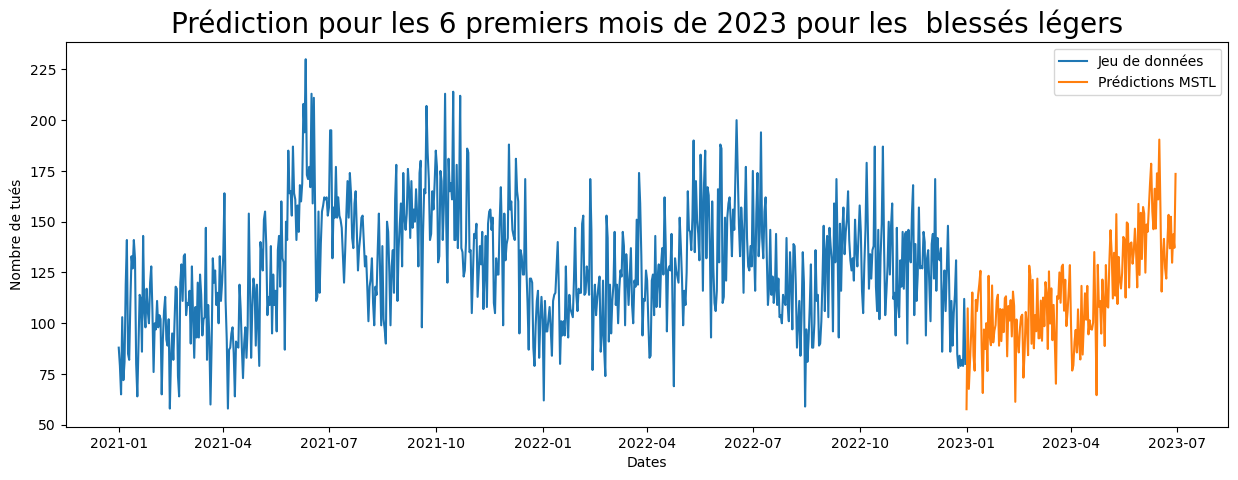

In [75]:
plt.figure(figsize = (15, 5))
plt.plot(df_bl2['ds'], df_bl2['y'], label = 'Jeu de données')
plt.plot(Y_pred['ds'], Y_pred['MSTL'], label = 'Prédictions MSTL')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de tués')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les  blessés légers", {'fontsize' : 20})
plt.show()

### Implémentation du modèle MSTL avec AutoTheta comme trend_forecaster

In [76]:
horizon = len(test)

models = [MSTL(season_length=[7, 7 * 52], 
               trend_forecaster=AutoTheta(prediction_intervals=ConformalIntervals(n_windows=3, h=horizon)))]

In [77]:
sf = StatsForecast(models = models,
                   freq = 'D',     # Pour weekly frequency
                   n_jobs = -1)

• Entraînement du modèle

In [78]:
sf.fit(df = train)

StatsForecast(models=[MSTL])

In [79]:
Y_test_pred = sf.forecast(horizon, fitted=True)
Y_test_pred

ds        MSTL
unique_id                       
1         2022-10-20  124.481209
1         2022-10-21  195.850754
1         2022-10-22   99.980911
1         2022-10-23  122.874840
1         2022-10-24  115.797722
...              ...         ...
1         2022-12-27   78.453445
1         2022-12-28   69.111313
1         2022-12-29   65.778648
1         2022-12-30   84.077576
1         2022-12-31   72.818039

[73 rows x 2 columns]

In [80]:
values = sf.forecast_fitted_values()
values.head()

ds      y        MSTL
unique_id                              
1         2021-01-01   88.0   99.683823
1         2021-01-02   79.0   80.554260
1         2021-01-03   65.0   55.636951
1         2021-01-04  103.0  101.826080
1         2021-01-05   72.0   82.563713

In [81]:
Y_test_pred = Y_test_pred.reset_index()
Y_test_pred

unique_id         ds        MSTL
0          1 2022-10-20  124.481209
1          1 2022-10-21  195.850754
2          1 2022-10-22   99.980911
3          1 2022-10-23  122.874840
4          1 2022-10-24  115.797722
..       ...        ...         ...
68         1 2022-12-27   78.453445
69         1 2022-12-28   69.111313
70         1 2022-12-29   65.778648
71         1 2022-12-30   84.077576
72         1 2022-12-31   72.818039

[73 rows x 3 columns]

In [82]:
Y_test_pred1 = Y_test_pred.merge(right = test, how = 'inner', on = ['ds', 'unique_id'])
Y_test_pred1

unique_id         ds        MSTL    y
0          1 2022-10-20  124.481209  149
1          1 2022-10-21  195.850754  187
2          1 2022-10-22   99.980911  138
3          1 2022-10-23  122.874840  104
4          1 2022-10-24  115.797722  115
..       ...        ...         ...  ...
68         1 2022-12-27   78.453445   79
69         1 2022-12-28   69.111313   82
70         1 2022-12-29   65.778648   79
71         1 2022-12-30   84.077576  112
72         1 2022-12-31   72.818039   80

[73 rows x 4 columns]

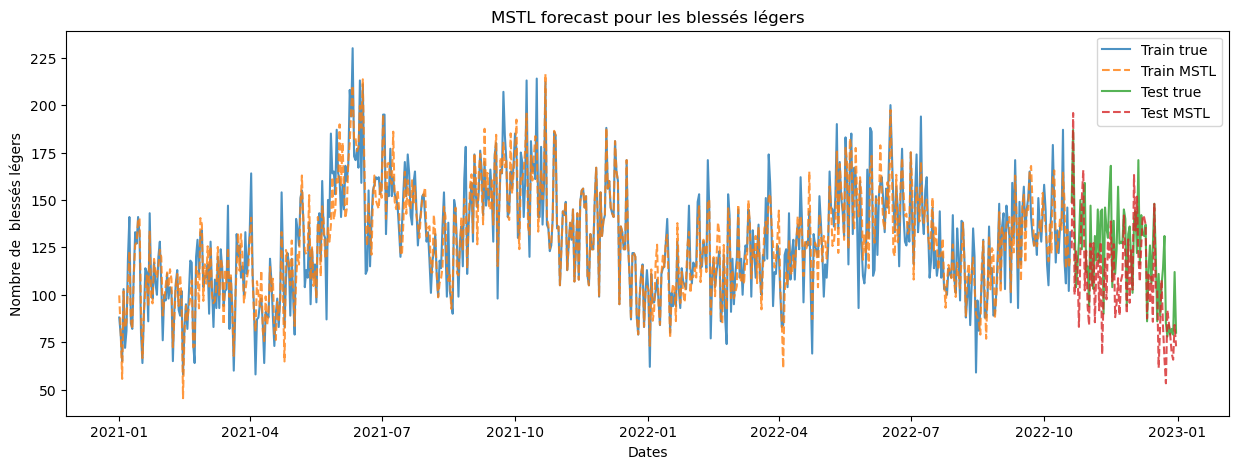

In [83]:
plt.figure(figsize = (15, 5))
plt.plot(values['ds'], values['y'], alpha = 0.8, label = 'Train true')
plt.plot(values['ds'], values['MSTL'], alpha = 0.8, label = 'Train MSTL', linestyle = "dashed")
plt.plot(Y_test_pred1['ds'], Y_test_pred1['y'], alpha = 0.8, label = 'Test true')
plt.plot(Y_test_pred1['ds'], Y_test_pred1['MSTL'], alpha = 0.8, label = 'Test MSTL', linestyle = "dashed")
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de  blessés légers')
plt.title("MSTL forecast pour les blessés légers")
plt.show()

In [84]:
fcast = sf.forecast(h=horizon, level=[95])
fcast

ds        MSTL  MSTL-lo-95  MSTL-hi-95
unique_id                                               
1         2022-10-20  124.481209  121.476097  127.486313
1         2022-10-21  195.850754  171.345291  220.356216
1         2022-10-22   99.980911   85.162460  114.799362
1         2022-10-23  122.874840   88.627312  157.122375
1         2022-10-24  115.797722   93.752747  137.842697
...              ...         ...         ...         ...
1         2022-12-27   78.453445   40.399078  116.507805
1         2022-12-28   69.111313   39.169300   99.053314
1         2022-12-29   65.778648   50.085522   81.471779
1         2022-12-30   84.077576   56.326164  111.828987
1         2022-12-31   72.818039   29.211462  116.424606

[73 rows x 4 columns]

In [85]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(values['ds'][-90 :], values['y'][-90 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(fcast['ds'], fcast['MSTL'], "k--",label = 'Test MSTL', alpha = 0.6)
ax.fill_between(fcast['ds'], fcast['MSTL-lo-95'], fcast['MSTL-hi-95'], color='k', alpha=0.1)
ax.set_title("Agrandissement de la partie droite de MSTL forecast pour les  blessés légers")
plt.show()

• Evaluation du modèle

In [86]:
train_predictions = values['MSTL']
test_predictions = Y_test_pred1['MSTL']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                 8.888519         20.321386
1      MSE               142.088147        692.533219
2     RMSE                11.920073         26.316026


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [87]:
sf.fit(df = df_bl2)

StatsForecast(models=[MSTL])

Prédiction pour les 6 prochains mois

In [88]:
horizon = 181

In [89]:
Y_pred = sf.forecast(horizon, fitted=True)
Y_pred

ds        MSTL
unique_id                       
1         2023-01-01   57.499142
1         2023-01-02  107.875572
1         2023-01-03   66.445251
1         2023-01-04   81.480553
1         2023-01-05   95.172775
...              ...         ...
1         2023-06-26  151.497757
1         2023-06-27  128.860016
1         2023-06-28  142.842270
1         2023-06-29  136.171249
1         2023-06-30  172.555801

[181 rows x 2 columns]

In [90]:
plt.figure(figsize = (15, 5))
plt.plot(df_bl2['ds'], df_bl2['y'], label = 'Jeu de données')
plt.plot(Y_pred['ds'], Y_pred['MSTL'], label = 'Prédictions MSTL')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de  blessés légers')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les  blessés légers")
plt.show()

### Implémentation du modèle MSTL avec AutoCES comme trend_forecaster

In [91]:
horizon = len(test)

models = [MSTL(season_length=[7, 7 * 52], 
               trend_forecaster=AutoCES(prediction_intervals=ConformalIntervals(n_windows=3, h=horizon)))]

In [92]:
sf = StatsForecast(models = models,
                   freq = 'D',     # Pour weekly frequency
                   n_jobs = -1)

• Entraînement du modèle

In [93]:
sf.fit(df = train)

StatsForecast(models=[MSTL])

In [94]:
Y_test_pred = sf.forecast(horizon, fitted=True)
Y_test_pred

ds        MSTL
unique_id                       
1         2022-10-20  124.301155
1         2022-10-21  195.583344
1         2022-10-22   99.661812
1         2022-10-23  122.493889
1         2022-10-24  115.357880
...              ...         ...
1         2022-12-27   74.279800
1         2022-12-28   64.880516
1         2022-12-29   61.490738
1         2022-12-30   79.732590
1         2022-12-31   68.416008

[73 rows x 2 columns]

In [95]:
values = sf.forecast_fitted_values()
values.head()

ds      y        MSTL
unique_id                              
1         2021-01-01   88.0   95.544014
1         2021-01-02   79.0   77.520226
1         2021-01-03   65.0   53.421093
1         2021-01-04  103.0  100.187691
1         2021-01-05   72.0   81.314522

In [96]:
Y_test_pred = Y_test_pred.reset_index()
Y_test_pred

unique_id         ds        MSTL
0          1 2022-10-20  124.301155
1          1 2022-10-21  195.583344
2          1 2022-10-22   99.661812
3          1 2022-10-23  122.493889
4          1 2022-10-24  115.357880
..       ...        ...         ...
68         1 2022-12-27   74.279800
69         1 2022-12-28   64.880516
70         1 2022-12-29   61.490738
71         1 2022-12-30   79.732590
72         1 2022-12-31   68.416008

[73 rows x 3 columns]

In [97]:
Y_test_pred1 = Y_test_pred.merge(right = test, how = 'inner', on = ['ds', 'unique_id'])
Y_test_pred1

unique_id         ds        MSTL    y
0          1 2022-10-20  124.301155  149
1          1 2022-10-21  195.583344  187
2          1 2022-10-22   99.661812  138
3          1 2022-10-23  122.493889  104
4          1 2022-10-24  115.357880  115
..       ...        ...         ...  ...
68         1 2022-12-27   74.279800   79
69         1 2022-12-28   64.880516   82
70         1 2022-12-29   61.490738   79
71         1 2022-12-30   79.732590  112
72         1 2022-12-31   68.416008   80

[73 rows x 4 columns]

In [98]:
plt.figure(figsize = (15, 5))
plt.plot(values['ds'], values['y'], alpha = 0.8, label = 'Train true')
plt.plot(values['ds'], values['MSTL'], alpha = 0.8, label = 'Train MSTL', linestyle = "dashed")
plt.plot(Y_test_pred1['ds'], Y_test_pred1['y'], alpha = 0.8, label = 'Test true')
plt.plot(Y_test_pred1['ds'], Y_test_pred1['MSTL'], alpha = 0.8, label = 'Test MSTL', linestyle = "dashed")
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de  blessés légers')
plt.title("MSTL forecast pour les  blessés légers")
plt.show()

In [99]:
fcast = sf.forecast(h=horizon, level=[95])
fcast

ds        MSTL  MSTL-lo-95  MSTL-hi-95
unique_id                                               
1         2022-10-20  124.301155  121.206711  127.395592
1         2022-10-21  195.583344  171.362793  219.803879
1         2022-10-22   99.661812   85.157921  114.165710
1         2022-10-23  122.493889   88.693893  156.293884
1         2022-10-24  115.357880   93.833107  136.882645
...              ...         ...         ...         ...
1         2022-12-27   74.279800   39.798145  108.761452
1         2022-12-28   64.880516   32.943474   96.817551
1         2022-12-29   61.490738   41.764492   81.216988
1         2022-12-30   79.732590   56.277676  103.187508
1         2022-12-31   68.416008   27.342384  109.489624

[73 rows x 4 columns]

In [100]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(values['ds'][-90 :], values['y'][-90 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(fcast['ds'], fcast['MSTL'], "k--",label = 'Test MSTL', alpha = 0.6)
ax.fill_between(fcast['ds'], fcast['MSTL-lo-95'], fcast['MSTL-hi-95'], color='k', alpha=0.1)
ax.set_title("Agrandissement de la partie droite de MSTL forecast pour les blessés légers")

Text(0.5, 1.0, 'Agrandissement de la partie droite de MSTL forecast pour les blessés légers')

• Evaluation du modèle

In [101]:
train_predictions = values['MSTL']
test_predictions = Y_test_pred1['MSTL']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                 8.897059         21.521700
1      MSE               141.974007        760.909324
2     RMSE                11.915285         27.584585


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [102]:
sf.fit(df = df_bl2)

StatsForecast(models=[MSTL])

Prédiction pour les 6 prochains mois

In [103]:
horizon = 181

In [104]:
Y_pred = sf.forecast(horizon, fitted=True)
Y_pred

ds        MSTL
unique_id                       
1         2023-01-01   57.345783
1         2023-01-02  107.695732
1         2023-01-03   66.227852
1         2023-01-04   81.228340
1         2023-01-05   94.885094
...              ...         ...
1         2023-06-26  145.346268
1         2023-06-27  122.675674
1         2023-06-28  136.625061
1         2023-06-29  129.921204
1         2023-06-30  166.272919

[181 rows x 2 columns]

In [105]:
plt.figure(figsize = (15, 5))
plt.plot(df_bl2['ds'], df_bl2['y'], label = 'Jeu de données')
plt.plot(Y_pred['ds'], Y_pred['MSTL'], label = 'Prédictions MSTL')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés légers')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les blessés légers")
plt.show()

# Entraînement et évaluation d'un modèle PROPHET

### PROPHET + saisonnalité hebdomadaire et annuelle

In [106]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False)

In [107]:
my_model.fit(train)

14:51:40 - cmdstanpy - INFO - Chain [1] start processing
14:51:40 - cmdstanpy - INFO - Chain [1] done processing


In [108]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_legers_PROPHET_train.joblib")

['../../../data/saved_models/Blesses_legers_PROPHET_train.joblib']

In [109]:
test_dates = my_model.make_future_dataframe(periods = len(test), freq = 'D')
test_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
725 2022-12-27
726 2022-12-28
727 2022-12-29
728 2022-12-30
729 2022-12-31

[730 rows x 1 columns]

In [110]:
forecast = my_model.predict(test_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        yhat  yhat_lower  yhat_upper
0 2021-01-01  105.518799   81.377536  130.179244
1 2021-01-02   93.413705   70.213095  117.901211
2 2021-01-03   71.301378   47.452268   93.742033
3 2021-01-04   79.515068   53.642080  102.867363
4 2021-01-05   88.601593   63.586535  112.259398

In [111]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y'], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'], forecast['yhat'], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='k', alpha=0.1)
ax.set_title("MSTL forecast pour les blessés légers")
plt.legend()
plt.show()

In [112]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'][-181 :], train['y'][-181 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'][-(181 + len(test)) :], forecast['yhat'][-(181 + len(test)) :], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'][-(181 + len(test)) :], forecast['yhat_lower'][-(181 + len(test)) :], forecast['yhat_upper'][-(181 + len(test)) :], color='k', alpha=0.1)
ax.set_title("Agrandissement de la partie droite de MSTL forecast pour blessés légers")
plt.legend()
plt.show()

• Evaluation du modèle

In [113]:
train_predictions = forecast['yhat'][ : len(train)]
test_predictions = forecast['yhat'][len(train) : ]

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                14.918499         26.984655
1      MSE               344.156180       1015.305696
2     RMSE                18.551447         31.863862


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [114]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False)

In [115]:
my_model.fit(df_bl2)

14:51:41 - cmdstanpy - INFO - Chain [1] start processing


14:51:41 - cmdstanpy - INFO - Chain [1] done processing


In [116]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_legers_PROPHET_df.joblib")

['../../../data/saved_models/Blesses_legers_PROPHET_df.joblib']

Prédiction pour les 6 prochains mois

In [117]:
futur_dates = my_model.make_future_dataframe(periods = 181, freq = 'D')
futur_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
906 2023-06-26
907 2023-06-27
908 2023-06-28
909 2023-06-29
910 2023-06-30

[911 rows x 1 columns]

In [118]:
forecast = my_model.predict(futur_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        yhat  yhat_lower  yhat_upper
0 2021-01-01  104.181928   79.832553  127.226043
1 2021-01-02   92.524575   69.145927  116.756594
2 2021-01-03   70.150295   45.896835   92.877878
3 2021-01-04   79.604077   57.027324  103.875267
4 2021-01-05   86.779862   61.483099  111.360687

In [119]:
plt.figure(figsize = (15, 5))
plt.plot(df_bl2['ds'], df_bl2['y'], label = 'Jeu de données')
plt.plot(forecast['ds'][-181 : ], forecast['yhat'][-181 : ], label = 'Prédictions PROPHET')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés légers')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les blessés légers")
plt.show()

### PROPHET + ajout des vacances scolaires communes

In [120]:
# Vacances scolaires
vac = pd.read_csv(conf['local_data_path'] + "vacances_scolaires.csv",sep = ";")
vac['jour'] = vac['date'].apply(lambda x : x.split("/")[0])
vac['mois'] = vac['date'].apply(lambda x : x.split("/")[1])
vac['an'] = vac['date'].apply(lambda x : x.split("/")[2])
vac

date  vacances_zone_a  vacances_zone_b  vacances_zone_c  \
0      01/01/1990            False            False            False   
1      02/01/1990            False            False            False   
2      03/01/1990            False            False            False   
3      04/01/1990            False            False            False   
4      05/01/1990            False            False            False   
...           ...              ...              ...              ...   
13509  27/12/2026            False            False            False   
13510  28/12/2026            False            False            False   
13511  29/12/2026            False            False            False   
13512  30/12/2026            False            False            False   
13513  31/12/2026            False            False            False   

      nom_vacances jour mois    an  
0              NaN   01   01  1990  
1              NaN   02   01  1990  
2              NaN   03   01  1990  
3              NaN   04   01  1990  
4              NaN   05   01  1990  
...            ...  ...  ...   ...  
13509          NaN   27   12  2026  
13510          NaN   28   12  2026  
13511          NaN   29   12  2026  
13512          NaN   30   12  2026  
13513          NaN   31   12  2026  

[13514 rows x 8 columns]

In [121]:
y_m_j = vac['an'].astype('str') + "-" + vac['mois'].astype('str') + "-" + vac['jour'].astype('str')
vac.insert(loc = 0, column = 'y_m_j', value = y_m_j)
vac = vac.drop(['date', 'an', 'mois', 'jour'], axis = 1)
vac.head()

y_m_j  vacances_zone_a  vacances_zone_b  vacances_zone_c nom_vacances
0  1990-01-01            False            False            False          NaN
1  1990-01-02            False            False            False          NaN
2  1990-01-03            False            False            False          NaN
3  1990-01-04            False            False            False          NaN
4  1990-01-05            False            False            False          NaN

In [122]:
vac = vac.loc[(vac['vacances_zone_a'] == True) & (vac['vacances_zone_b'] == True) & (vac['vacances_zone_c'] == True)]
#vac = vac.drop(['vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c', 'nom_vacances'], axis = 1)
vac

y_m_j  vacances_zone_a  vacances_zone_b  vacances_zone_c  \
299    1990-10-27             True             True             True   
300    1990-10-28             True             True             True   
301    1990-10-29             True             True             True   
302    1990-10-30             True             True             True   
303    1990-10-31             True             True             True   
...           ...              ...              ...              ...   
13386  2026-08-26             True             True             True   
13387  2026-08-27             True             True             True   
13388  2026-08-28             True             True             True   
13389  2026-08-29             True             True             True   
13390  2026-08-30             True             True             True   

                   nom_vacances  
299    Vacances de la Toussaint  
300    Vacances de la Toussaint  
301    Vacances de la Toussaint  
302    Vacances de la Toussaint  
303    Vacances de la Toussaint  
...                         ...  
13386            Vacances d'‚t‚  
13387            Vacances d'‚t‚  
13388            Vacances d'‚t‚  
13389            Vacances d'‚t‚  
13390            Vacances d'‚t‚  

[3440 rows x 5 columns]

In [123]:
vac = vac[(vac['y_m_j'] >= '2021-01-01') & (vac['y_m_j'] < '2023-07-01')]
vac

y_m_j  vacances_zone_a  vacances_zone_b  vacances_zone_c  \
11323  2021-01-01             True             True             True   
11324  2021-01-02             True             True             True   
11325  2021-01-03             True             True             True   
11373  2021-02-20             True             True             True   
11374  2021-02-21             True             True             True   
...           ...              ...              ...              ...   
12054  2023-01-02             True             True             True   
12101  2023-02-18             True             True             True   
12102  2023-02-19             True             True             True   
12164  2023-04-22             True             True             True   
12165  2023-04-23             True             True             True   

                nom_vacances  
11323       Vacances de No‰l  
11324       Vacances de No‰l  
11325       Vacances de No‰l  
11373       Vacances d'hiver  
11374       Vacances d'hiver  
...                      ...  
12054       Vacances de No‰l  
12101       Vacances d'hiver  
12102       Vacances d'hiver  
12164  Vacances de printemps  
12165  Vacances de printemps  

[202 rows x 5 columns]

In [124]:
vac = vac.set_index(vac['y_m_j'])
vac

y_m_j  vacances_zone_a  vacances_zone_b  vacances_zone_c  \
y_m_j                                                                       
2021-01-01  2021-01-01             True             True             True   
2021-01-02  2021-01-02             True             True             True   
2021-01-03  2021-01-03             True             True             True   
2021-02-20  2021-02-20             True             True             True   
2021-02-21  2021-02-21             True             True             True   
...                ...              ...              ...              ...   
2023-01-02  2023-01-02             True             True             True   
2023-02-18  2023-02-18             True             True             True   
2023-02-19  2023-02-19             True             True             True   
2023-04-22  2023-04-22             True             True             True   
2023-04-23  2023-04-23             True             True             True   

                     nom_vacances  
y_m_j                              
2021-01-01       Vacances de No‰l  
2021-01-02       Vacances de No‰l  
2021-01-03       Vacances de No‰l  
2021-02-20       Vacances d'hiver  
2021-02-21       Vacances d'hiver  
...                           ...  
2023-01-02       Vacances de No‰l  
2023-02-18       Vacances d'hiver  
2023-02-19       Vacances d'hiver  
2023-04-22  Vacances de printemps  
2023-04-23  Vacances de printemps  

[202 rows x 5 columns]

In [125]:
vac_date = []
for i in range(len(vac)):
    vac_date.append(vac.index[i])
    
vac_date

['2021-01-01',
 '2021-01-02',
 '2021-01-03',
 '2021-02-20',
 '2021-02-21',
 '2021-04-24',
 '2021-04-25',
 '2021-05-13',
 '2021-05-14',
 '2021-05-15',
 '2021-05-16',
 '2021-05-17',
 '2021-07-06',
 '2021-07-07',
 '2021-07-08',
 '2021-07-09',
 '2021-07-10',
 '2021-07-11',
 '2021-07-12',
 '2021-07-13',
 '2021-07-14',
 '2021-07-15',
 '2021-07-16',
 '2021-07-17',
 '2021-07-18',
 '2021-07-19',
 '2021-07-20',
 '2021-07-21',
 '2021-07-22',
 '2021-07-23',
 '2021-07-24',
 '2021-07-25',
 '2021-07-26',
 '2021-07-27',
 '2021-07-28',
 '2021-07-29',
 '2021-07-30',
 '2021-07-31',
 '2021-08-01',
 '2021-08-02',
 '2021-08-03',
 '2021-08-04',
 '2021-08-05',
 '2021-08-06',
 '2021-08-07',
 '2021-08-08',
 '2021-08-09',
 '2021-08-10',
 '2021-08-11',
 '2021-08-12',
 '2021-08-13',
 '2021-08-14',
 '2021-08-15',
 '2021-08-16',
 '2021-08-17',
 '2021-08-18',
 '2021-08-19',
 '2021-08-20',
 '2021-08-21',
 '2021-08-22',
 '2021-08-23',
 '2021-08-24',
 '2021-08-25',
 '2021-08-26',
 '2021-08-27',
 '2021-08-28',
 '2021-08-

In [126]:
vacances = pd.DataFrame({'holiday' : 'vacances',
                        'ds' : pd.to_datetime(vac_date)})

vacances

holiday         ds
0    vacances 2021-01-01
1    vacances 2021-01-02
2    vacances 2021-01-03
3    vacances 2021-02-20
4    vacances 2021-02-21
..        ...        ...
197  vacances 2023-01-02
198  vacances 2023-02-18
199  vacances 2023-02-19
200  vacances 2023-04-22
201  vacances 2023-04-23

[202 rows x 2 columns]

In [127]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False,
                   holidays = vacances)

In [128]:
my_model.fit(train)

14:51:41 - cmdstanpy - INFO - Chain [1] start processing


14:51:41 - cmdstanpy - INFO - Chain [1] done processing


In [129]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_legers_PROPHET_vacances_train.joblib")

['../../../data/saved_models/Blesses_legers_PROPHET_vacances_train.joblib']

In [130]:
test_dates = my_model.make_future_dataframe(periods = len(test), freq = 'D')
test_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
725 2022-12-27
726 2022-12-28
727 2022-12-29
728 2022-12-30
729 2022-12-31

[730 rows x 1 columns]

In [131]:
forecast = my_model.predict(test_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  98.818584   77.533291  121.032521
1 2021-01-02  87.007235   63.368890  110.585603
2 2021-01-03  64.205653   42.200845   88.562068
3 2021-01-04  85.558148   61.484809  108.632578
4 2021-01-05  93.944612   70.540905  116.506329

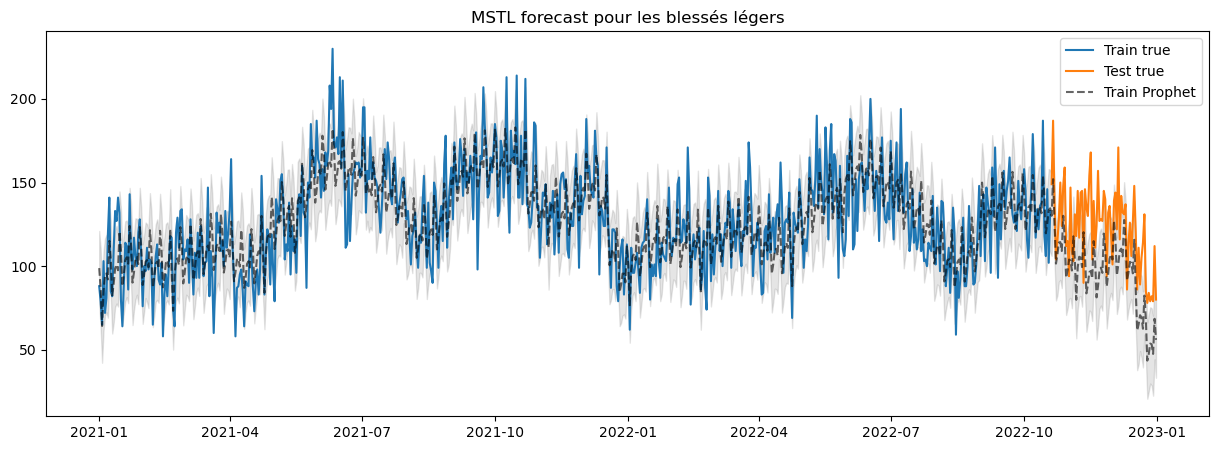

In [132]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y'], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'], forecast['yhat'], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='k', alpha=0.1)
ax.set_title("MSTL forecast pour les blessés légers")
plt.legend()
plt.show()

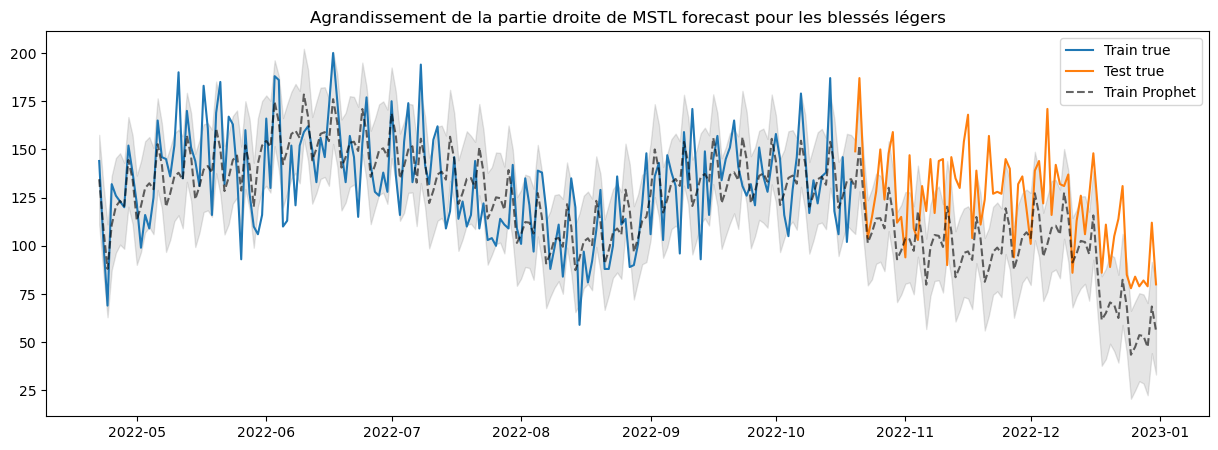

In [133]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'][-181 :], train['y'][-181 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'][-(181 + len(test)) :], forecast['yhat'][-(181 + len(test)) :], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'][-(181 + len(test)) :], forecast['yhat_lower'][-(181 + len(test)) :], forecast['yhat_upper'][-(181 + len(test)) :], color='k', alpha=0.1)
ax.set_title("Agrandissement de la partie droite de MSTL forecast pour les blessés légers")
plt.legend()
plt.show()

• Evaluation du modèle

In [134]:
train_predictions = forecast['yhat'][ : len(train)]
test_predictions = forecast['yhat'][len(train) : ]

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                14.694587         27.976132
1      MSE               333.323846       1036.037045
2     RMSE                18.257159         32.187529


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [135]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False,
                   holidays = vacances)

In [136]:
my_model.fit(df_bl2)

14:51:42 - cmdstanpy - INFO - Chain [1] start processing


14:51:42 - cmdstanpy - INFO - Chain [1] done processing


In [137]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_legers_PROPHET_vacances_df.joblib")

['../../../data/saved_models/Blesses_legers_PROPHET_vacances_df.joblib']

In [138]:
futur_dates = my_model.make_future_dataframe(periods = 181, freq = 'D')
futur_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
906 2023-06-26
907 2023-06-27
908 2023-06-28
909 2023-06-29
910 2023-06-30

[911 rows x 1 columns]

In [139]:
forecast = my_model.predict(futur_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  97.366268   74.803890  120.870943
1 2021-01-02  86.298623   59.459020  110.029417
2 2021-01-03  63.328206   39.000500   87.591226
3 2021-01-04  85.633938   60.507271  108.700264
4 2021-01-05  92.190386   67.293496  116.515585

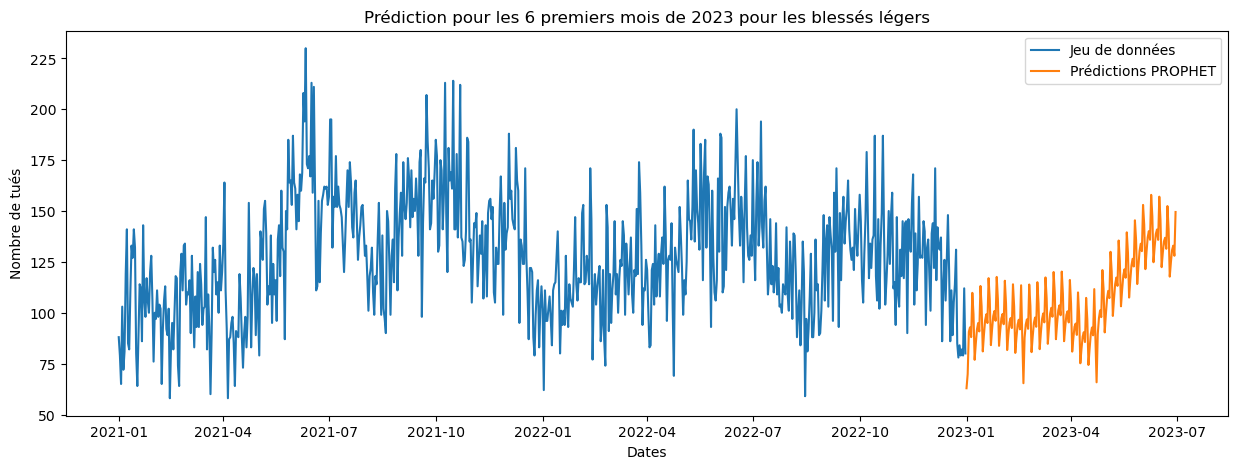

In [140]:
plt.figure(figsize = (15, 5))
plt.plot(df_bl2['ds'], df_bl2['y'], label = 'Jeu de données')
plt.plot(forecast['ds'][-181 : ], forecast['yhat'][-181 : ], label = 'Prédictions PROPHET')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de tués')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les blessés légers")
plt.show()

### PROPHET + ajout des jours fériés communs

In [141]:
#Lecture du fichier des jours fériés
feries = pd.read_csv(conf['local_data_path'] +"jours_feries.csv", sep = ",", low_memory=False)

feries

date            nom_jour_ferie  \
0    2004-01-01               1er janvier   
1    2004-04-09            Vendredi saint   
2    2004-04-12           Lundi de Pâques   
3    2004-04-27  Abolition de l'esclavage   
4    2004-05-01                   1er mai   
..          ...                       ...   
501  2029-11-01                 Toussaint   
502  2029-11-11               11 novembre   
503  2029-12-20  Abolition de l'esclavage   
504  2029-12-25              Jour de Noël   
505  2029-12-26         2ème jour de Noël   

                                                 zones  
0    Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
1                                       Alsace-Moselle  
2    Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
3                                              Mayotte  
4    Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
..                                                 ...  
501  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
502  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
503                                         La Réunion  
504  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
505                                     Alsace-Moselle  

[506 rows x 3 columns]

In [142]:
feries = feries[(feries['date'] >= '2021-01-01') & (feries['date'] < '2023-07-01')]
feries

date            nom_jour_ferie  \
326  2021-01-01               1er janvier   
327  2021-04-02            Vendredi saint   
328  2021-04-05           Lundi de Pâques   
329  2021-04-27  Abolition de l'esclavage   
330  2021-05-01                   1er mai   
331  2021-05-08                     8 mai   
332  2021-05-13                 Ascension   
333  2021-05-22  Abolition de l'esclavage   
334  2021-05-24        Lundi de Pentecôte   
335  2021-05-27  Abolition de l'esclavage   
336  2021-05-28  Abolition de l'esclavage   
337  2021-06-10  Abolition de l'esclavage   
338  2021-07-14                14 juillet   
339  2021-08-15                Assomption   
340  2021-10-09  Abolition de l'esclavage   
341  2021-11-01                 Toussaint   
342  2021-11-11               11 novembre   
343  2021-12-20  Abolition de l'esclavage   
344  2021-12-25              Jour de Noël   
345  2021-12-26         2ème jour de Noël   
346  2022-01-01               1er janvier   
347  2022-04-15            Vendredi saint   
348  2022-04-18           Lundi de Pâques   
349  2022-04-27  Abolition de l'esclavage   
350  2022-05-01                   1er mai   
351  2022-05-08                     8 mai   
352  2022-05-22  Abolition de l'esclavage   
353  2022-05-26                 Ascension   
354  2022-05-27  Abolition de l'esclavage   
355  2022-05-28  Abolition de l'esclavage   
356  2022-06-06        Lundi de Pentecôte   
357  2022-06-10  Abolition de l'esclavage   
358  2022-07-14                14 juillet   
359  2022-08-15                Assomption   
360  2022-10-09  Abolition de l'esclavage   
361  2022-11-01                 Toussaint   
362  2022-11-11               11 novembre   
363  2022-12-20  Abolition de l'esclavage   
364  2022-12-25              Jour de Noël   
365  2022-12-26         2ème jour de Noël   
366  2023-01-01               1er janvier   
367  2023-04-07            Vendredi saint   
368  2023-04-10           Lundi de Pâques   
369  2023-04-27  Abolition de l'esclavage   
370  2023-05-01                   1er mai   
371  2023-05-08                     8 mai   
372  2023-05-18                 Ascension   
373  2023-05-22  Abolition de l'esclavage   
374  2023-05-27  Abolition de l'esclavage   
375  2023-05-28  Abolition de l'esclavage   
376  2023-05-29        Lundi de Pentecôte   
377  2023-06-10  Abolition de l'esclavage   

                                                 zones  
326  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
327                                     Alsace-Moselle  
328  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
329                                            Mayotte  
330  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
331  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
332  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
333                                         Martinique  
334  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
335                                         Guadeloupe  
336                                       Saint-Martin  
337                                             Guyane  
338  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
339  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
340                                   Saint-Barthélémy  
341  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
342  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
343                                         La Réunion  
344  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
345                                     Alsace-Moselle  
346  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
347                                     Alsace-Moselle  
348  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
349                                            Mayotte  
350  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
351  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
352                                         Martinique  
353  Métropole|Alsace-Moselle

In [143]:
feries['nom_jour_ferie'].unique

<bound method Series.unique of 326                 1er janvier
327              Vendredi saint
328             Lundi de Pâques
329    Abolition de l'esclavage
330                     1er mai
331                       8 mai
332                   Ascension
333    Abolition de l'esclavage
334          Lundi de Pentecôte
335    Abolition de l'esclavage
336    Abolition de l'esclavage
337    Abolition de l'esclavage
338                  14 juillet
339                  Assomption
340    Abolition de l'esclavage
341                   Toussaint
342                 11 novembre
343    Abolition de l'esclavage
344                Jour de Noël
345           2ème jour de Noël
346                 1er janvier
347              Vendredi saint
348             Lundi de Pâques
349    Abolition de l'esclavage
350                     1er mai
351                       8 mai
352    Abolition de l'esclavage
353                   Ascension
354    Abolition de l'esclavage
355    Abolition de l'esclavage
356      

In [144]:
for index, item in zip(feries.index, feries['nom_jour_ferie']) :
    if item == "Abolition de l'esclavage":
        feries = feries.drop(index)

In [145]:
for index, item in zip(feries.index, feries['nom_jour_ferie']) :
    if item == "Vendredi saint":
        feries = feries.drop(index)

In [146]:
for index, item in zip(feries.index, feries['nom_jour_ferie']) :
    if item == "2ème jour de Noël":
        feries = feries.drop(index)

In [147]:
feries = feries.set_index(feries['date'])
feries

date      nom_jour_ferie  \
date                                         
2021-01-01  2021-01-01         1er janvier   
2021-04-05  2021-04-05     Lundi de Pâques   
2021-05-01  2021-05-01             1er mai   
2021-05-08  2021-05-08               8 mai   
2021-05-13  2021-05-13           Ascension   
2021-05-24  2021-05-24  Lundi de Pentecôte   
2021-07-14  2021-07-14          14 juillet   
2021-08-15  2021-08-15          Assomption   
2021-11-01  2021-11-01           Toussaint   
2021-11-11  2021-11-11         11 novembre   
2021-12-25  2021-12-25        Jour de Noël   
2022-01-01  2022-01-01         1er janvier   
2022-04-18  2022-04-18     Lundi de Pâques   
2022-05-01  2022-05-01             1er mai   
2022-05-08  2022-05-08               8 mai   
2022-05-26  2022-05-26           Ascension   
2022-06-06  2022-06-06  Lundi de Pentecôte   
2022-07-14  2022-07-14          14 juillet   
2022-08-15  2022-08-15          Assomption   
2022-11-01  2022-11-01           Toussaint   
2022-11-11  2022-11-11         11 novembre   
2022-12-25  2022-12-25        Jour de Noël   
2023-01-01  2023-01-01         1er janvier   
2023-04-10  2023-04-10     Lundi de Pâques   
2023-05-01  2023-05-01             1er mai   
2023-05-08  2023-05-08               8 mai   
2023-05-18  2023-05-18           Ascension   
2023-05-29  2023-05-29  Lundi de Pentecôte   

                                                        zones  
date                                                           
2021-01-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-04-05  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-05-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-05-08  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-05-13  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-05-24  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-07-14  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-08-15  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-11-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-11-11  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-12-25  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-01-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-04-18  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-05-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-05-08  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-05-26  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-06-06  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-07-14  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-08-15  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-11-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-11-11  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-12-25  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-01-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-04-10  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-05-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-05-08  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-05-18  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-05-29  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...

In [148]:
feries_date = []
for i in range(len(feries)):
    feries_date.append(feries.index[i])
    
feries_date

['2021-01-01',
 '2021-04-05',
 '2021-05-01',
 '2021-05-08',
 '2021-05-13',
 '2021-05-24',
 '2021-07-14',
 '2021-08-15',
 '2021-11-01',
 '2021-11-11',
 '2021-12-25',
 '2022-01-01',
 '2022-04-18',
 '2022-05-01',
 '2022-05-08',
 '2022-05-26',
 '2022-06-06',
 '2022-07-14',
 '2022-08-15',
 '2022-11-01',
 '2022-11-11',
 '2022-12-25',
 '2023-01-01',
 '2023-04-10',
 '2023-05-01',
 '2023-05-08',
 '2023-05-18',
 '2023-05-29']

In [149]:
jours_feries = pd.DataFrame({'holiday' : 'feries',
                            'ds' : pd.to_datetime(feries_date)})

jours_feries

holiday         ds
0   feries 2021-01-01
1   feries 2021-04-05
2   feries 2021-05-01
3   feries 2021-05-08
4   feries 2021-05-13
5   feries 2021-05-24
6   feries 2021-07-14
7   feries 2021-08-15
8   feries 2021-11-01
9   feries 2021-11-11
10  feries 2021-12-25
11  feries 2022-01-01
12  feries 2022-04-18
13  feries 2022-05-01
14  feries 2022-05-08
15  feries 2022-05-26
16  feries 2022-06-06
17  feries 2022-07-14
18  feries 2022-08-15
19  feries 2022-11-01
20  feries 2022-11-11
21  feries 2022-12-25
22  feries 2023-01-01
23  feries 2023-04-10
24  feries 2023-05-01
25  feries 2023-05-08
26  feries 2023-05-18
27  feries 2023-05-29

In [150]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False,
                   holidays = jours_feries)

In [151]:
my_model.fit(train)

14:51:43 - cmdstanpy - INFO - Chain [1] start processing


14:51:43 - cmdstanpy - INFO - Chain [1] done processing


In [152]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_legers_PROPHET_feries_train.joblib")

['../../../data/saved_models/Blesses_legers_PROPHET_feries_train.joblib']

In [153]:
test_dates = my_model.make_future_dataframe(periods = len(test), freq = 'D')
test_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
725 2022-12-27
726 2022-12-28
727 2022-12-29
728 2022-12-30
729 2022-12-31

[730 rows x 1 columns]

In [154]:
forecast = my_model.predict(test_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  85.029252   62.759201  108.916156
1 2021-01-02  96.204718   74.895910  120.532827
2 2021-01-03  73.719231   52.195784   95.616246
3 2021-01-04  82.507061   58.565528  104.057188
4 2021-01-05  89.987353   65.802599  112.617815

In [155]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y'], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'], forecast['yhat'], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='k', alpha=0.1)
ax.set_title("MSTL forecast pour les blessés légers")
plt.legend()
plt.show()

In [156]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'][-181 :], train['y'][-181 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'][-(181 + len(test)) :], forecast['yhat'][-(181 + len(test)) :], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'][-(181 + len(test)) :], forecast['yhat_lower'][-(181 + len(test)) :], forecast['yhat_upper'][-(181 + len(test)) :], color='k', alpha=0.1)
ax.set_title("MSTL forecast pour les blessés légers")
plt.legend()
plt.show()

• Evaluation du modèle

In [157]:
train_predictions = forecast['yhat'][ : len(train)]
test_predictions = forecast['yhat'][len(train) : ]

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                14.660347         25.922100
1      MSE               330.530498        963.253556
2     RMSE                18.180498         31.036326


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [158]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False)

In [159]:
my_model.fit(df_bl2)

14:51:44 - cmdstanpy - INFO - Chain [1] start processing


14:51:44 - cmdstanpy - INFO - Chain [1] done processing


In [160]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_legers_PROPHET_feries_df.joblib")

['../../../data/saved_models/Blesses_legers_PROPHET_feries_df.joblib']

In [161]:
futur_dates = my_model.make_future_dataframe(periods = 181, freq = 'D')
futur_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
906 2023-06-26
907 2023-06-27
908 2023-06-28
909 2023-06-29
910 2023-06-30

[911 rows x 1 columns]

In [162]:
forecast = my_model.predict(futur_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        yhat  yhat_lower  yhat_upper
0 2021-01-01  104.181928   80.980541  129.429119
1 2021-01-02   92.524575   68.999500  115.654503
2 2021-01-03   70.150295   47.033546   93.516519
3 2021-01-04   79.604077   54.306985  103.329279
4 2021-01-05   86.779862   62.994807  110.328394

In [163]:
plt.figure(figsize = (15, 5))
plt.plot(df_bl2['ds'], df_bl2['y'], label = 'Jeu de données')
plt.plot(forecast['ds'][-181 : ], forecast['yhat'][-181 : ], label = 'Prédictions PROPHET')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de tués')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les blessés légers")
plt.show()

# Entraînement et évaluation d'un modèle LSTM

### Vanilla LSTM

Préparation du jeu de données

En s'aidant de https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [164]:
dataset = df2.values
dataset

array([[ 88],
       [ 79],
       [ 65],
       [103],
       [ 72],
       [ 81],
       [119],
       [141],
       [ 85],
       [ 82],
       [110],
       [133],
       [127],
       [141],
       [132],
       [ 80],
       [ 64],
       [ 89],
       [114],
       [112],
       [ 86],
       [143],
       [106],
       [ 98],
       [117],
       [106],
       [100],
       [120],
       [128],
       [106],
       [ 76],
       [100],
       [ 97],
       [111],
       [ 98],
       [104],
       [102],
       [ 65],
       [ 92],
       [106],
       [113],
       [ 92],
       [ 89],
       [102],
       [ 58],
       [ 83],
       [ 95],
       [ 82],
       [100],
       [118],
       [117],
       [ 74],
       [ 64],
       [120],
       [129],
       [111],
       [133],
       [134],
       [104],
       [110],
       [109],
       [116],
       [ 90],
       [128],
       [103],
       [ 83],
       [108],
       [ 93],
       [120],
       [ 93],
       [124],
      

In [165]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

In [166]:
train_scaled, test_scaled = train_test_split(dataset_scaled, test_size = 0.1, shuffle = False)
print(len(train_scaled), len(test_scaled))

657 73


In [167]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [168]:
# reshape into X=t and Y=t+1
look_back = 31
trainX_scaled, trainY_scaled = create_dataset(train_scaled, look_back)
testX_scaled, testY_scaled = create_dataset(test_scaled, look_back)

In [169]:
trainX_scaled.shape, trainY_scaled.shape

((625, 31), (625,))

In [170]:
trainX_scaled, trainY_scaled

(array([[0.1744186 , 0.12209302, 0.04069767, ..., 0.40697674, 0.27906977,
         0.10465116],
        [0.12209302, 0.04069767, 0.26162791, ..., 0.27906977, 0.10465116,
         0.24418605],
        [0.04069767, 0.26162791, 0.08139535, ..., 0.10465116, 0.24418605,
         0.22674419],
        ...,
        [0.3372093 , 0.50581395, 0.5755814 , ..., 0.46511628, 0.75      ,
         0.34883721],
        [0.50581395, 0.5755814 , 0.44186047, ..., 0.75      , 0.34883721,
         0.27906977],
        [0.5755814 , 0.44186047, 0.50581395, ..., 0.34883721, 0.27906977,
         0.51162791]]),
 array([0.24418605, 0.22674419, 0.30813953, 0.23255814, 0.26744186,
        0.25581395, 0.04069767, 0.19767442, 0.27906977, 0.31976744,
        0.19767442, 0.18023256, 0.25581395, 0.        , 0.14534884,
        0.21511628, 0.13953488, 0.24418605, 0.34883721, 0.34302326,
        0.09302326, 0.03488372, 0.36046512, 0.4127907 , 0.30813953,
        0.43604651, 0.44186047, 0.26744186, 0.30232558, 0.29651163,
 

In [171]:
# reshape input to be [samples, time steps, features]
trainX_scaled= np.reshape(trainX_scaled, (trainX_scaled.shape[0], 1, trainX_scaled.shape[1]))
testX_scaled = np.reshape(testX_scaled, (testX_scaled.shape[0], 1, testX_scaled.shape[1]))

Création et entraînement du modèle

In [172]:
# On fixe un random seed pour la reporductibilité
tf.random.set_seed(7)

In [173]:
#Implémentation du modèle et entraînement
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(4),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX_scaled, trainY_scaled, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


625/625 - 1s - 1ms/step - loss: 0.0328
Epoch 2/100
625/625 - 0s - 646us/step - loss: 0.0191
Epoch 3/100
625/625 - 0s - 324us/step - loss: 0.0173
Epoch 4/100
625/625 - 0s - 334us/step - loss: 0.0162
Epoch 5/100
625/625 - 0s - 324us/step - loss: 0.0155
Epoch 6/100
625/625 - 0s - 327us/step - loss: 0.0151
Epoch 7/100
625/625 - 0s - 319us/step - loss: 0.0148
Epoch 8/100
625/625 - 0s - 330us/step - loss: 0.0147
Epoch 9/100
625/625 - 0s - 328us/step - loss: 0.0146
Epoch 10/100
625/625 - 0s - 566us/step - loss: 0.0145
Epoch 11/100
625/625 - 0s - 325us/step - loss: 0.0144
Epoch 12/100
625/625 - 0s - 328us/step - loss: 0.0143
Epoch 13/100
625/625 - 0s - 331us/step - loss: 0.0143
Epoch 14/100
625/625 - 0s - 373us/step - loss: 0.0142
Epoch 15/100
625/625 - 0s - 321us/step - loss: 0.0142
Epoch 16/100
625/625 - 0s - 323us/step - loss: 0.0142
Epoch 17/100
625/625 - 0s - 322us/step - loss: 0.0141
Epoch 18/100
625/625 - 0s - 605us/step - loss: 0.0141
Epoch 19/100
625/625 - 0s - 685us/step - loss: 0.01

In [174]:
model.save("../../../data/saved_models/Blesses_legers_LSTM.h5")

In [175]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (1, 4)                 │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 1)                 │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,745 (6.82 KB)

 Trainable params: 581 (2.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,164 (4.55 KB)

Évaluation du modèle

In [176]:
trainPredict = model.predict(trainX_scaled)
testPredict = model.predict(testX_scaled)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY_scaled])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY_scaled])

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
train_mse = mean_squared_error(trainY[0], trainPredict[:,0])
train_rmse = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(testY[0], testPredict[:,0])
test_mse = mean_squared_error(testY[0], testPredict[:,0])
test_rmse = mean_squared_error(testY[0], testPredict[:,0], squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

 1/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                14.855796         17.063169
1      MSE               352.358519        441.833595
2     RMSE                18.771215         21.019838


In [177]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1 : len(dataset_scaled)-1, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize = (15, 5))
plt.plot(df2.index, scaler.inverse_transform(dataset_scaled), label = 'True', alpha = 0.6)
plt.plot(df2.index, trainPredictPlot, "--", label = 'train predict')
plt.plot(df2.index, testPredictPlot, "--", label = 'test predict')
plt.legend()
plt.title("Prédictions sur train et test pour les blessés légers", {'fontsize' : 20})
plt.show()

Prédictions pour le prochain mois

In [178]:
sample = np.reshape(testX_scaled[-1], (1, 1, look_back))
pred_scaled = []
n = 31                  # Prédiction pour le prochain mois
for i in range(n):
    next_step = model.predict(sample)
    add_sample = np.append(sample, next_step)[1:]
    sample = np.reshape(add_sample, (1, 1, add_sample.shape[0]))
    pred_scaled.append(next_step[0,0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

In [179]:
pred_scaled = np.array(pred_scaled)
pred_scaled.shape
pred_scaled = pred_scaled.reshape(len(pred_scaled), 1)

In [180]:
pred = scaler.inverse_transform(pred_scaled)

In [181]:
start = datetime.datetime.strptime("2023-01-01", "%Y-%m-%d")
date_generate = pd.date_range(start, periods = n)
date_generate

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-14', '2023-01-15', '2023-01-16',
               '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20',
               '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24',
               '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-28',
               '2023-01-29', '2023-01-30', '2023-01-31'],
              dtype='datetime64[ns]', freq='D')

In [182]:
plt.figure(figsize = (15, 5))
plt.plot(df2.index, scaler.inverse_transform(dataset_scaled), label = 'True')
plt.plot(date_generate, pred, label = 'prédictions')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés légers')
plt.title("Prédictions pour le premier mois de 2023 pour les blessés légers", {'fontsize' : 20})
plt.show()